#CheXpert

In [0]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize

from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

use_gpu = torch.cuda.is_available()

Mount google drive

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
baseFolder  = "CheXpert-v1.0-small/"

In [0]:
#Utility functions for cleaning the data

def cleanLabel(x):
    
    labelCount = 0    
    if x.Pleural_Effusion == 1:
        labelCount += 1
    if x.Edema == 1:
        labelCount += 1
    if x.Cardiomegaly ==1:
        labelCount += 1
    if x.Pneumonia == 1:
        labelCount += 1
    return labelCount
    
    

def getLabel(x):
    
    if x.Pleural_Effusion ==1:
        return "Pleural_Effusion"
    elif x.Edema == 1:
        return "Edema"
    elif x.Cardiomegaly==1:
        return "Cardiomegaly"
    elif x.Pneumonia == 1:
        return "Pneumonia"
    else:
        return "None"

In [0]:


#Dataframe columns
cols = ['Path',
 'Sex',
 'Age',
 'View',
 'AP/PA',
 'No_Finding',
 'Enlarged_Cardiomediastinum',
 'Cardiomegaly',
 'Lung_Opacity',
 'Lung_Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Effusion',
 'Pleural_Other',
 'Fracture',
 'Support_Devices']

pathFileTrain = baseFolder + 'train.csv'
pathFileValid = baseFolder + 'valid.csv'

## Dataloader for using 14 classes

Need to change uncertain labels (Trying 1s policy)


In [0]:
#For 4 classes
labelMap = {"Pleural_Effusion":0, "Edema":1,"Cardiomegaly":2,"Pneumonia":3}

def getLabelDf(x):
    x = x[36:]          #To account for the extra "././" added before the Path variable
    x = df.loc[df.Path == x] 
    return labelMap[x.label.values[0]]

In [0]:
class LungDataset(Dataset):
    def __init__(self, baseFolder, file, transform=None, type="All"):
        image_files = []
        labels = []

        with open(file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                #print(line[0])
                image_file= line[0]
                if((type=="All") or (type=="Frontal" and image_file.endswith('frontal.jpg')) or (type == "Lateral" and image_file.endswith('lateral.jpg'))):
                    #Create a 14 class label with 0s and 1s for the corresponding pathologies
                    label = line[5:]

                    #Handling uncertainity
                    # TODO: Also try 0s for Us
                    for i in range(14):
                        if label[i]:
                            a = float(label[i])
                            if a == 1:
                                label[i] = 1
                            elif a == -1:
                                label[i] = 1
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0       
                    #TODO: Change when running locally!    
                    image_files.append(baseFolder + image_file)
                    labels.append(label)
                    
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels[index]
        location = self.image_files[index]
        image = Image.open(location).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_files)

In [0]:
img_size = (256, 256)
#Transformations
transformList = []
transformList.append(transforms.Resize(img_size))
transformList.append(transforms.ColorJitter(brightness=.05, hue=.05, saturation=.05))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))      
transformSequence=transforms.Compose(transformList)

In [0]:

#trainDataset = LungDataset('drive/My Drive/CheXpert Dataset/',pathFileValid, transformSequence)  
trainFrontalDataset = LungDataset('',pathFileTrain, transformSequence, "Frontal")
trainLateralDataset = LungDataset('',pathFileTrain, transformSequence, "Lateral")

validationDataset = LungDataset('',pathFileValid, transformSequence)  

In [0]:
print(validationDataset.__len__())
print(trainFrontalDataset.__len__())
print(trainLateralDataset.__len__())

234
191027
32387


In [0]:
e = next(iter(trainFrontalDataset))
e[0].size()

torch.Size([3, 256, 256])

In [0]:
train_frontal_data_loader = DataLoader(trainFrontalDataset, batch_size= 16, shuffle = True)
train_lateral_data_loader = DataLoader(trainLateralDataset, batch_size= 16, shuffle = True)

validation_loader = DataLoader(validationDataset, batch_size= 16, shuffle = True)

In [0]:
for image, label in train_lateral_data_loader:
    print(label)
    
    break;

tensor([[0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

## Logger

In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

Ngrok already installed


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: https://c4555ec8.ngrok.io


In [0]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
logger = Logger('./logs')


## DenseNet for images - 14 class output

In [0]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [0]:
device = torch.device('cuda:0')

input_size = 196608
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        self.densenet = torchvision.models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Sequential(
            nn.Linear(self.densenet.classifier.in_features, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.densenet(x)
        return x


In [0]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs, size, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    for epoch in range(epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            #print(loss)
            optimizer.step()
            _, prediction = torch.max(outputs,1)
            #print(outputs)
            #print(labels)
            #print(prediction)
            ##total += labels.size(0)
            #correct += (prediction==labels).sum().item()
            #accuracy = (labels == prediction.squeeze()).float().mean()
            overall_step+=1
            del images
            del labels
            if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item()}

              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)
    

### Create the frontal model (Densenet 121)

In [0]:
    # print(outputs)
    # print(labels)    # print(outputs)
    # print(labels)
num_classes = 14
learning_rate = 0.0001
model_frontal = Net(num_classes).cuda()
criterion = torch.nn.BCELoss(size_average = True)
optimizer_frontal = torch.optim.Adam (model_frontal.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
epochs = 3



###Train the frontal network only on frontal images

In [0]:
## Train the frontal model
torch.cuda.empty_cache()
train(model_frontal, optimizer_frontal, criterion, train_frontal_data_loader, validation_loader, epochs, input_size , 'front', True)

torch.save(model_frontal.state_dict(), "densenet_frontal.pt")

Epoch [1/3], Step [100/11940], Loss: 0.4110
Epoch [1/3], Step [200/11940], Loss: 0.3745
Epoch [1/3], Step [300/11940], Loss: 0.4158
Epoch [1/3], Step [400/11940], Loss: 0.4055
Epoch [1/3], Step [500/11940], Loss: 0.3816
Epoch [1/3], Step [600/11940], Loss: 0.3685
Epoch [1/3], Step [700/11940], Loss: 0.3978
Epoch [1/3], Step [800/11940], Loss: 0.3433
Epoch [1/3], Step [900/11940], Loss: 0.3493
Epoch [1/3], Step [1000/11940], Loss: 0.3362
Epoch [1/3], Step [1100/11940], Loss: 0.3610
Epoch [1/3], Step [1200/11940], Loss: 0.3810
Epoch [1/3], Step [1300/11940], Loss: 0.3232
Epoch [1/3], Step [1400/11940], Loss: 0.3824
Epoch [1/3], Step [1500/11940], Loss: 0.4147
Epoch [1/3], Step [1600/11940], Loss: 0.3305
Epoch [1/3], Step [1700/11940], Loss: 0.3409
Epoch [1/3], Step [1800/11940], Loss: 0.3539
Epoch [1/3], Step [1900/11940], Loss: 0.3977
Epoch [1/3], Step [2000/11940], Loss: 0.3883
Epoch [1/3], Step [2100/11940], Loss: 0.3643
Epoch [1/3], Step [2200/11940], Loss: 0.3668
Epoch [1/3], Step [

Epoch [2/3], Step [6500/11940], Loss: 0.3510
Epoch [2/3], Step [6600/11940], Loss: 0.3401
Epoch [2/3], Step [6700/11940], Loss: 0.3072
Epoch [2/3], Step [6800/11940], Loss: 0.2966
Epoch [2/3], Step [6900/11940], Loss: 0.3431
Epoch [2/3], Step [7000/11940], Loss: 0.3045
Epoch [2/3], Step [7100/11940], Loss: 0.3211
Epoch [2/3], Step [7200/11940], Loss: 0.3293
Epoch [2/3], Step [7300/11940], Loss: 0.3558
Epoch [2/3], Step [7400/11940], Loss: 0.3262
Epoch [2/3], Step [7500/11940], Loss: 0.3493
Epoch [2/3], Step [7600/11940], Loss: 0.3223
Epoch [2/3], Step [7700/11940], Loss: 0.2976
Epoch [2/3], Step [7800/11940], Loss: 0.2616
Epoch [2/3], Step [7900/11940], Loss: 0.3342
Epoch [2/3], Step [8000/11940], Loss: 0.3241
Epoch [2/3], Step [8100/11940], Loss: 0.3322
Epoch [2/3], Step [8200/11940], Loss: 0.3194
Epoch [2/3], Step [8300/11940], Loss: 0.3619
Epoch [2/3], Step [8400/11940], Loss: 0.3106
Epoch [2/3], Step [8500/11940], Loss: 0.3031
Epoch [2/3], Step [8600/11940], Loss: 0.3275
Epoch [2/3

### Create the lateral model 

In [0]:

model_lateral = Net(num_classes).cuda()
optimizer_lateral = torch.optim.Adam (model_lateral.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
epochs = 6 # might want to train for more epochs (lesser lateral data)


###Train the lateral network only on lateral images

In [0]:
## Train the frontal model

train(model_lateral, optimizer_lateral, criterion, train_lateral_data_loader, validation_loader, epochs, input_size , 'lat', True)

torch.save(model_frontal.state_dict(), "densenet_lateral.pt")

Epoch [1/6], Step [100/2025], Loss: 0.3977
Epoch [1/6], Step [200/2025], Loss: 0.3147
Epoch [1/6], Step [300/2025], Loss: 0.4457
Epoch [1/6], Step [400/2025], Loss: 0.4452
Epoch [1/6], Step [500/2025], Loss: 0.3604
Epoch [1/6], Step [600/2025], Loss: 0.4595
Epoch [1/6], Step [700/2025], Loss: 0.4552
Epoch [1/6], Step [800/2025], Loss: 0.3470
Epoch [1/6], Step [900/2025], Loss: 0.4617
Epoch [1/6], Step [1000/2025], Loss: 0.3932
Epoch [1/6], Step [1100/2025], Loss: 0.4277
Epoch [1/6], Step [1200/2025], Loss: 0.3783
Epoch [1/6], Step [1300/2025], Loss: 0.3066
Epoch [1/6], Step [1400/2025], Loss: 0.3143
Epoch [1/6], Step [1500/2025], Loss: 0.2954
Epoch [1/6], Step [1600/2025], Loss: 0.3248
Epoch [1/6], Step [1700/2025], Loss: 0.4219
Epoch [1/6], Step [1800/2025], Loss: 0.3232
Epoch [1/6], Step [1900/2025], Loss: 0.3765
Epoch [1/6], Step [2000/2025], Loss: 0.3246
Epoch [2/6], Step [100/2025], Loss: 0.3461
Epoch [2/6], Step [200/2025], Loss: 0.3683
Epoch [2/6], Step [300/2025], Loss: 0.4131


### Predicting on testing set
For each patient, compute output based on the frontal image and an output based on the lateral image (if present). Combine the results by traking the max of the the two predictions

In [0]:
### Loader for getting btoh frontal images and lateral images for a study

test_df = pd.read_csv(pathFileValid)
#test_df['root'] = test_df['path']
x = test_df['Path'].str.split("/", n = 4, expand = True)
test_df['PatientStudyId'] = (x[2] + x[3])
test_df['PatientStudyId'] = test_df['PatientStudyId'].astype(str)


In [0]:
frontal_df = test_df[test_df['Frontal/Lateral'] == 'Frontal']
lateral_df = test_df[test_df['Frontal/Lateral'] == 'Lateral']
combined_df = pd.merge(frontal_df, lateral_df, on='PatientStudyId', how='outer', suffixes=('_frontal', '_lateral'))
combined_df = combined_df[['Path_frontal', 'Path_lateral']]

combined_df = combined_df.where((pd.notnull(combined_df)), None)
front_lateral_dict = combined_df.set_index('Path_frontal').to_dict()
lateral_front_dict = combined_df.set_index('Path_lateral').to_dict()


#### Create test dataset given the combined front and lateral image maps

In [0]:
front_lateral_dict = front_lateral_dict['Path_lateral']
lateral_front_dict = lateral_front_dict['Path_frontal']


In [0]:
from torch.autograd import Variable

class CombinedTestDataset(Dataset):
    def __init__(self, baseFolder, file,  front_lat_dict, lat_front_dict, transform=None):
        frontal_image_files = []
        lateral_image_files = []
        labels = []
        hasFrontal = []
        hasLateral = []
        with open(file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                #print(line[0])
                
                image_file= line[0]
                if(line[3] == 'Frontal'):
                    lateral_img_path = front_lat_dict[image_file]
                    frontal_image_files.append(baseFolder + image_file)
                    hasFrontal.append(True)
                    if(lateral_img_path is not None):
                        lateral_image_files.append(baseFolder + lateral_img_path)
                        hasLateral.append(True)
                    else:
                        lateral_image_files.append(None)
                        hasLateral.append(False)
                
                else:
                    frontal_image_path =  lat_front_dict[image_file]
                    lateral_image_files.append(baseFolder + image_file)
                    hasLateral.append(True)
                    if(frontal_image_path is not None):
                        hasFrontal.append(True)
                        frontal_image_files.append(baseFolder + frontal_image_path)
                    else:
                        hasFrontal.append(False)
                        frontal_image_files.append(None)
                
                #Create a 14 class label with 0s and 1s for the corresponding pathologies
                label = line[5:]

                #Handling uncertainity
                # TODO: Also try 0s for Us
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            label[i] = 1
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0       
                #TODO: Change when running locally!    
                labels.append(label)
                    
        self.frontal_image_files = frontal_image_files
        self.lateral_image_files = lateral_image_files
        self.labels = labels
        self.transform = transform
        self.hasFrontal = hasFrontal
        self.hasLateral = hasLateral
        
    def __getitem__(self, index):
        label = self.labels[index]
        frontal_location = self.frontal_image_files[index]
        hasF = self.hasFrontal[index]
        hasL = self.hasLateral[index]
        
        frontal_image = None
        if(hasF):
            frontal_image = Image.open(frontal_location).convert('RGB')
            if self.transform is not None:
                frontal_image = self.transform(frontal_image)
                
        
        lateral_location = self.lateral_image_files[index]
        lateral_image = None
        if(hasL):
            lateral_image = Image.open(lateral_location).convert('RGB')
            if self.transform is not None:
                lateral_image = self.transform(lateral_image)
        hasFTensor = torch.ones([1,1])
        hasLTensor = torch.ones([1,1])
        if(frontal_image is None):
            hasFTensor = torch.zeros([1,1])
            frontal_image = lateral_image
        elif(lateral_image is None):
            hasLTensor = torch.zeros([1,1])
            lateral_image = frontal_image
        
        
        return frontal_image, lateral_image, torch.FloatTensor(label), hasFTensor, hasLTensor

    def __len__(self):
        return len(self.frontal_image_files)

In [0]:

testDataset = CombinedTestDataset('',pathFileValid, front_lateral_dict, lateral_front_dict, transformSequence)  

In [0]:
e = next(iter(testDataset))
e[0].size()

torch.Size([3, 256, 256])

#### Create the test dataloader


In [0]:
test_loader = DataLoader(testDataset, batch_size= 1, shuffle = True)

In [0]:
for i, (images_f, images_l, labels, has_f, has_l) in enumerate(test_loader):
    print(images_f.size())
    print(images_l.size())
    print(has_f.size())
    
    break;

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 1])


In [0]:

def computeAUROCCombined (data, predicted, classCount):

    auroc = []

    data_np = data.cpu().numpy()
    data_np_pred = predicted.cpu().numpy()

    for i in range(classCount):
        try:
            auroc.append(roc_auc_score(data_np[:, i], data_np_pred[:, i]))
        except ValueError:
            pass
    return auroc



def testCombined(modelFrontal, modelLateral, test_loader, class_count, class_names):   

   
    out = torch.FloatTensor().cuda()
    out_pred = torch.FloatTensor().cuda()
    modelFrontal.eval()
    modelLateral.eval()
    with torch.no_grad():
        for imageF, imageL, label, hasF, hasL in test_loader:
            imageF = imageF.to(device)
            imageL = imageL.to(device)
            
            target = label.cuda()
            out = torch.cat((out, target), 0).cuda()
            hasFSum = hasF.float().sum().data.item()
            hasLSum = hasL.float().sum().data.item()
            if hasFSum != 0 and hasLSum != 0:
                outF = modelFrontal(imageF)
                outL = modelLateral(imageL)
                outV = torch.max(outF, outL)
            elif hasLSum != 0:
                outV = modelLateral(imageL)
            else:
                outV = modelFrontal(imageF)
                
            outV = outV.cuda()
            
            out_pred = torch.cat((out_pred, outV), 0).cuda()
        
    aurocIndividual = computeAUROCCombined(out, out_pred, class_count)
    aurocMean = np.array(aurocIndividual).mean()

    print ('AUROC mean ', aurocMean)

    for i in range (0, len(aurocIndividual)):
        print (class_names[i], ' ', aurocIndividual[i])

    return out, out_pred

In [0]:

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
out, out_pred = testCombined(model_frontal, model_lateral, test_loader, 14, class_names)

No Finding   0.8795649838882922
Enlarged Cardiomediastinum   0.6089174311926605
Cardiomegaly   0.8248582565556343
Lung Opacity   0.9235743680188124
Lung Lesion   0.7193133047210301
Edema   0.9261610817166372
Consolidation   0.8454696215890246
Pneumonia   0.6877212389380531
Atelectasis   0.7846590909090909
Pneumothorax   0.8788716814159292
Pleural Effusion   0.9104477611940298
Pleural Other   0.8111587982832618
Fracture   0.9588637868864522


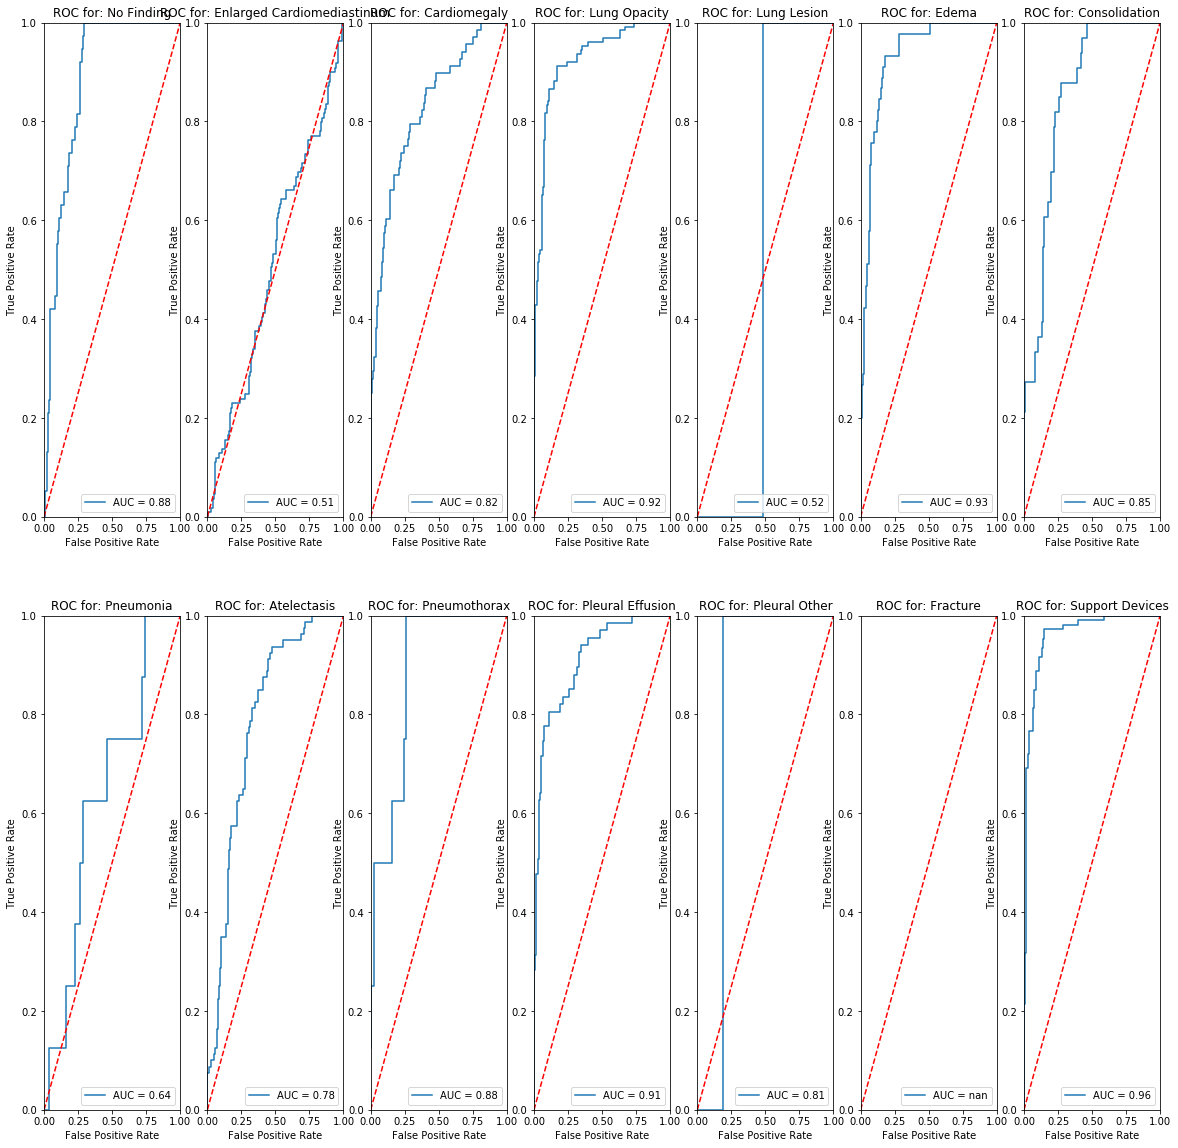

In [0]:
for i in range(14):
    fpr, tpr, threshold = metrics.roc_curve(out.cpu()[:,i], out_pred.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

plt.show()